In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import os

# Seg Map imports
from scipy.ndimage import label
from astropy.table import Table
from astropy.io import fits

# grizli imports
from grizli.model import GrismFLT
import pysynphot as S

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Read in Table and sort with highest Z first
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

# Store len and instantiate empty seg_map
total_obj = len(hlss_tbl)
seg_map = np.zeros((4088,4088))

In [28]:
hlss_tbl[hlss_tbl["NUMBER"] == 208537]

NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,MAG_F1500W,SPECTEMP,Z,MODIMAGE,MODIMAGE_1,MODIMAGE_2
int64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64
208537,2337.05,3992.0297,8.0,8.0,0.0,27.0,197363,0.0,1,-1000.0,-1000.0


In [26]:
x = 2466
y = 1166
range = 10 # pix
coords = (abs(hlss_tbl["X_IMAGE"] - x) < range) & (abs(hlss_tbl["Y_IMAGE"] - y) < range)
index = np.where(coords)

hlss_tbl[index].pprint_all()

IndexError: index 208537 out of range for table with length 10763

In [102]:
star = lambda x, y, x_0, y_0: (x-x_0)**2 + (y-y_0)**2

y = np.arange(4088)
x = np.arange(4088)
x_grid, y_grid = np.meshgrid(x,y)
del x
del y

In [103]:
object = hlss_tbl[index]

num = object["NUMBER"][0]
x_0 = object["X_IMAGE"][0]
y_0 = object["Y_IMAGE"][0]

test_star = lambda x, y: star(x, y, x_0, y_0)


condition = test_star(x_grid, y_grid) <= 60**2

seg_map[np.where(condition)] = num

In [104]:
direct_file = "/Users/keith/astr/research_astr/summer-roman-project/psf/fits/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
seg_file = "test_seg.fits"

file = fits.open(direct_file)
hdr = file[1].header
file.close()

fits.writeto(seg_file, data=np.rot90(seg_map, k=3), header=hdr, overwrite=True)

In [105]:
# Create Grizli GrismFLT instance
pad=100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/keith/astr/research_astr/summer-roman-project/psf/fits/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/keith/astr/research_astr/summer-roman-project/psf/fits/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation test_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


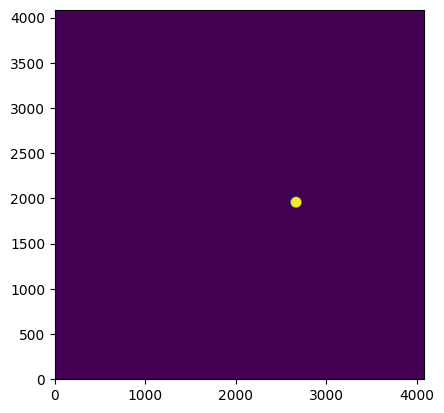

In [106]:
plt.imshow(np.rot90(seg_map, k=3), origin='lower')

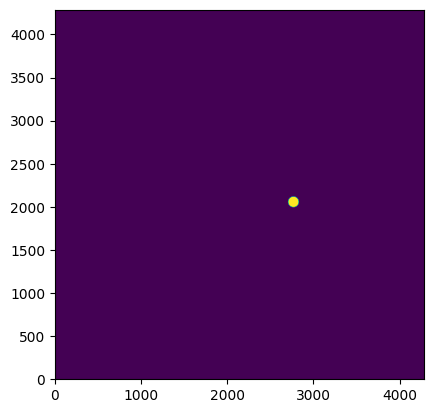

In [107]:
plt.imshow(roman_sim.seg, origin='lower')

In [108]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Pull object characteristics
mag = object["MAG_F1500W"][0]
sed = "SED:rest:gal.{0}.fits".format(object["SPECTEMP"][0])


# Create Spectrum array object
sed_path = os.path.join(SED_dir, sed)
spectrum = Table.read(sed_path, format="fits")
rest_wave = spectrum["wavelength"]
flux = spectrum["flux"]

z = (10000 / rest_wave.min()) - 1

redshift_wave = rest_wave * (z + 1)

# Compute pysynphot Spectrum
spec = S.ArraySpectrum(wave=redshift_wave, flux=flux, waveunits="angstrom", fluxunits="flam")
spec = spec.renorm(mag, "abmag", bp) # Redshift lambda and normalize flux with bandpass object

roman_sim.compute_model_orders(id=num, mag=mag, compute_size=False, size=77, 
                                in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

True

(700.0, 1900.0)

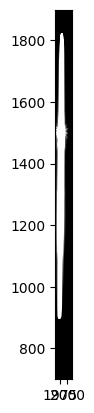

In [109]:
upright_img = np.rot90(roman_sim.model)[pad:-pad, pad:-pad]
plt.imshow(upright_img, origin='lower', cmap="grey", vmin=0.5, vmax=1.2)
plt.xlim(1960, 2015)
plt.ylim(700, 1900)

In [110]:
# Primary HDU is opened and closed above. Comment out direct_fits.close() if you plan to save here.
file = fits.open(direct_file)
header = file[1].header
PrimaryHDU = file[0]

ImageHDU = fits.ImageHDU(data=upright_img, header=header, name='SCI')
err_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='ERR')
DQ_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='DQ')

hdul = [PrimaryHDU, ImageHDU, err_HDU, DQ_HDU]

fits.HDUList(hdul).writeto("single_object.fits", overwrite=True)

file.close()